# Machine Learning for Textual Data - Donald Trump's Tweets
<b> Advanced Numberical Methods and Data Analysis - University of St. Gallen (HSG) - Spring semester 2019 </b>

Elisa Fleissner       (14-350-608)

Lars Stauffenegger    (tbd)

Alexander Steeb       (tbd)

07.05.2019

--------------------------------------------------------------------------------------------

# Project plan
Two models: Word count/frequency (LDA) and word2vec


In [1]:
import sys
print(sys.executable)
print(sys.version)

/usr/local/Cellar/python/3.7.2_2/bin/python3.7
3.7.2 (default, Feb 12 2019, 08:15:36) 
[Clang 10.0.0 (clang-1000.11.45.5)]


## 0. Setup

In [2]:
# import functions
import json
import os
import pandas as pd

import re

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexandersteeb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Data import

Source:
https://sites.google.com/site/ruwach/bibletext

In [68]:
import requests, zipfile, io
old_zip_file_url = "https://sites.google.com/site/ruwach/Basic_English_OldTestament.zip?attredirects=0"
new_zip_file_url = "https://sites.google.com/site/ruwach/Basic_English_NewTestament.zip?attredirects=0"

def unzip(url):
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall("data/")
    
unzip(old_zip_file_url)
unzip(new_zip_file_url)

In [249]:
path = "data"
df = pd.DataFrame()  


testaments = os.listdir(path)

for testament in testaments:
    testament_path = os.path.join(path,testament)
    books = os.listdir(testament_path)
    print(testament)
    
    for book in books:
        book_path = os.path.join(testament_path,book)
        files = os.listdir(book_path)    
            
        for file in files:
            file_path = os.path.join(book_path,file) 
            
            with open(file_path,"r", encoding="utf-8") as infile:
                text = infile.read()
                df = df.append([[text, testament, book, file, file_path]], ignore_index=True)
                
df.columns = ["text", "testament", "book", "file", "path"]



Old Testament
New Testament


In [250]:
books = (
    "Genesis",
    "Exodus",
    "Leviticus",
    "Numbers",
    "Deuteronomy",
    "Joshua",
    "Judges",
    "Ruth",
    "1 Samuel",
    "2 Samuel",
    "1 Kings",
    "2 Kings",
    "1 Chronicles",
    "2 Chronicles",
    "Ezra",
    "Nehemiah",
    "Esther",
    "Job",
    "Psalms",
    "Proverbs",
    "Ecclesiastes",
    "Song of Solomon",
    "Isaiah",
    "Jeremiah",
    "Lamentations",
    "Ezekiel",
    "Daniel",
    "Hosea",
    "Joel",
    "Amos",
    "Obadiah",
    "Jonah",
    "Micah",
    "Nahum",
    "Habbakuk",
    "Zephaniah",
    "Haggai",
    "Zechariah",
    "Malachi",
    "Matthew",
    "Mark",
    "Luke",
    "John",
    "Acts",
    "Romans",
    "1 Corinthians",
    "2 Corinthians",
    "Galatians",
    "Ephesians",
    "Philippians",
    "Colossians",
    "1 Thessalonians",
    "2 Thessalonians",
    "1 Timothy",
    "2 Timothy",
    "Titus",
    "Philemon",
    "Hebrews",
    "James",
    "1-2 Peter",
    "1-3 John",
    "Jude",
    "Revalation")


In [251]:
books_order = pd.DataFrame.from_records(zip(books, range(1,len(books))))

books_order.columns = ["book", "order"]

df = pd.merge(df,books_order, on='book')

In [254]:
df

text  \
0     1 Now the land was in bitter need of food.\n2 And when the grain which they had got in Egypt was all used up, their father said to them, Go again and get us a little food.\n3 And Judah said to him, The man said to us with an oath, You are not to come before me again without your brother.\n4 If you will let our brother go with us, we will go down and get food:\n5 But if you will not send him, we will not go down: for the man said to us, You are not to come before me if your brother is not with you.\n6 And Israel said, Why were you so cruel to me as to say to him that you had a brother?\n7 And they said, The man put a number of questions to us about ourselves and our family, saying, Is your father still living? have you another brother? And we had to give him answers; how were we to have any idea that he would say, Come back with your brother?\n8 Then Judah said to Israel, his father, Send the boy with me, and let us be up and going, so that we and you and our little ones may not come to destruction.\n9 Put him into my care and make me responsible for him: if I do not give him safely back to you, let mine be the sin for ever.\n10 Truly, if we had not let the time go by, we might have come back again by now.\n11 Then their father Israel said to them, If it has to be so, then do this: take of the best fruits of the land in your vessels to give the man, perfumes and honey and spices and nuts:\n12 And take twice as much money with you; that is to say, take back the money which was put in your bags, for it may have been an error;\n13 And take your brother and go back to the man:\n14 And may God, the Ruler of all, give you mercy before the man, so that he may give you back your other brother and Benjamin. If my children are to be taken from me; there is no help for it.\n15 So they took what their father said for the man, and twice as much money in their hands, and Benjamin, and went on their journey to Egypt, and came before Joseph.\n16 And when Joseph saw Benjamin, he said to his chief servant, Take these men into my house, and make ready a meal, for they will take food with me in the middle of the day.\n17 And the servant did as Joseph said, and took the men into Joseph's house.\n18 Now the men were full of fear because they had been taken into Joseph's house and they said, It is because of the money which was put back in our bags the first time; he is looking for something against us, so that he may come down on us and take us and our asses for his use.\n19 So they went up to Joseph's chief servant at the door of the house,\n20 And said, O my lord, we only came down the first time to get food;\n21 And when we came to our night's resting-place, on opening our bags we saw that every man's money was in the mouth of his bag, all our money in full weight: and we have it with us to give it back;\n22 As well as more money, with which to get food: we have no idea who put our money in our bags.\n23 Then the servant said, Peace be with you: have no fear: your God, even the God of your father, has put wealth in your bags for you: I had your money. Then he let Simeon come out to them.\n24 And the servant took them into Joseph's house, and gave them water for washing their feet; and he gave their asses food.\n25 And they got ready the things for Joseph before he came in the middle of the day: for word was given to them that they were to have a meal there.\n26 And when Joseph came in, they gave him the things which they had for him, and went down to the earth before him.\n27 And he said, How are you? is your father well, the old man of whom you were talking to me? is he still living?\n28 And they said, Your servant, our father, is well, he is still living. And they went down on their faces before him.\n29 Then, lifting up his eyes, he saw Benjamin, his brother, his mother's son, and he said, Is this your youngest brother of whom you gave me word? And he said, God be good to you, my son.\n30 Then Joseph's heart went out to his broth

In [253]:
df = df.sort_values("order")
df.reset_index(drop=True, inplace=True)

## 2. Data cleaning

Data cleaning: Stemming, tokenization, see other documentation
Data visualisation (eg wordcloud)
Data inspection

In [256]:
def preprocessor(text):
    '''removing all punctuation, non-letter characters and white spaces'''
    text.strip()
    text = (re.sub('[\W]+', ' ', text.lower()))      #remove non-word characters and make text lowercase
    text = (re.sub('[\d]+', '', text))               #to remove numbers [0-9]
    text = (re.sub('\n', ' ', text))

    return text.strip()

def tokenizer(text):
    '''split text into single words and return a list of these words'''
    return text.split()

def remove_stopwords(text):
    stop = stopwords.words('english')
    words = [word for word in text.split()]
    stopremoved = [w for w in words if w not in stop]
    return ' '.join(stopremoved)

def tokenizer_porter(text):
    '''Porter stemmer - split text and convert all words back to 
    their stem, e.g. running -> run, return a list of the stemmed words'''
    
    stop = stopwords.words('english')
    porter = PorterStemmer()
    
    stopremoved = [w for w in text.split() if w not in stop] #removing common stop words as downloaded from nltk package
    stem = [porter.stem(word) for word in stopremoved]

    return " ".join(stopremoved)

In [257]:
pd.set_option('display.max_colwidth', -1)
#df.head()

In [258]:
#wordcloud_df.head()

In [259]:
#apply preprocessor for Wordcloud and merge all preprocessed speeches to one text
wordcloud_df = df['text'].apply(preprocessor)
wordcloud_df = wordcloud_df.apply(remove_stopwords)

full_text = ''
for text in wordcloud_df:
    full_text += text

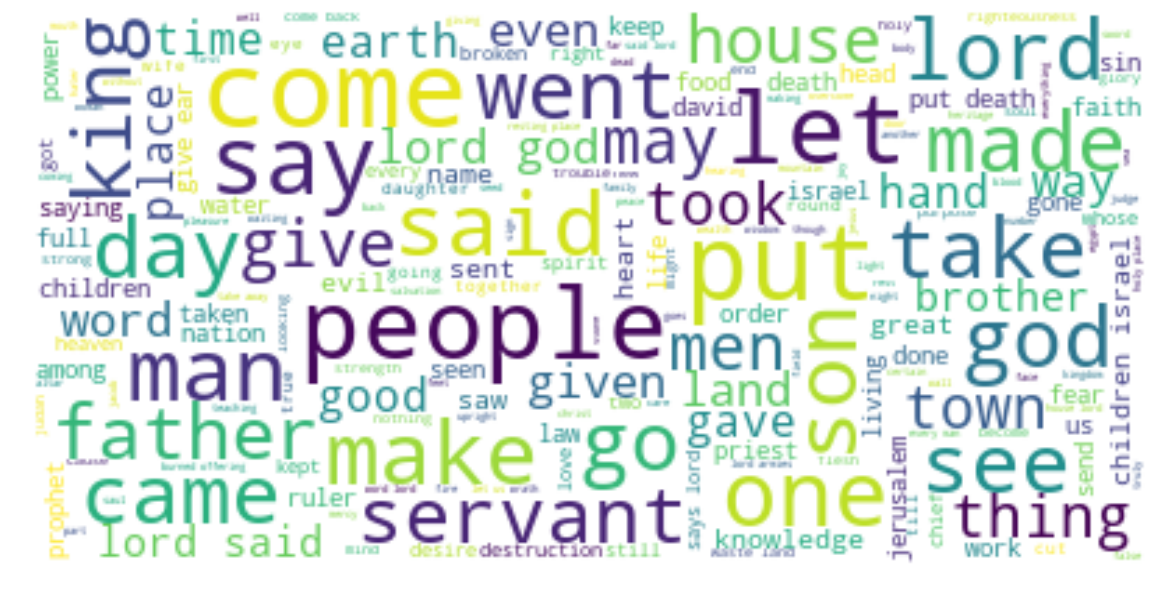

In [260]:
# generate word cloud 
wordcloud = WordCloud(max_font_size=40,background_color="white").generate(full_text)

# display
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## 3. Model 1 - LDA

see documentation - Elisa 

In [261]:
# apply preprocessor for LDA

# apply preprocessor to speeches in data frame
df['cleaned'] = df['text']
df['cleaned'] = df['cleaned'].apply(preprocessor)

#Processing documents into tokens (incl. stemming and removing stopwords)
df['cleaned'] = df['cleaned'].apply(tokenizer_porter)

In [304]:
n_components = 3

#Transformation Into Feature Vectors that count how often words appear in different speeches
count = CountVectorizer(
            max_df=0.95,
            min_df=2,
            max_features=100_000,
            ngram_range=(1,2)
            )

#for testament in testaments:
#    text = df.loc[df['testament'] == testament,"cleaned"]
text = df.loc[:,"cleaned"]
X = count.fit_transform(text)  #sparse matrix

#fit LDA 
lda = LatentDirichletAllocation(n_components=n_components, random_state=1000, learning_method='batch')

nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5)


X_topics = lda.fit_transform(X)
#X_topics = nmf.fit_transform(X)

lda.components_.shape
#print 5 most important words of every topic
print(testament)
print("The five most important words of three topics are:")
print()
n_top_words = 10
feature_names = count.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names[i]
    for i in topic.argsort()\
        [:-n_top_words - 1:-1]]))
print()
print()

New Testament
The five most important words of three topics are:

Topic 1:
lord give let put come make god take made like
Topic 2:
said god man give put come one made came jesus
Topic 3:
lord said king israel put son went people came land




In [305]:
X

<1136x46753 sparse matrix of type '<class 'numpy.int64'>'
	with 360190 stored elements in Compressed Sparse Row format>

In [306]:
#for topic 1 to 5
print('Presidents in order of gving most weight to the specific topics')

titles = ['1', '2', '3',"4","5"]

for no in range(5):
    topic = X_topics[:, no].argsort()[::-1]  #sort in descending order and return index 
    print()
    print("Topic", titles[no])
    print('-'*40)
    presi = []
    for speech in topic:
        presi.append(df['book'][speech])
        if len(set(presi)) == 3: #make sure we only pick the 3 top presidents who belong in topic the most
            break 
            
    #Keep order in list but remove duplicates
    output = []
    seen = set()
    for p in presi:
        # If value has not been encountered yet, add it to both list and set.
        if p not in seen:
            output.append(p)
            seen.add(p)

    for p in output:
        print(p)

Presidents in order of gving most weight to the specific topics

Topic 1
----------------------------------------
Numbers
Leviticus
Exodus

Topic 2
----------------------------------------
Mark
Matthew
Luke

Topic 3
----------------------------------------
1 Kings
1 Samuel
Judges


IndexError: index 3 is out of bounds for axis 1 with size 3

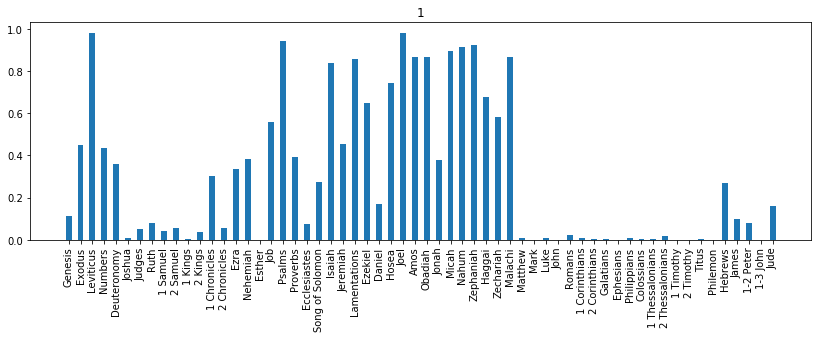

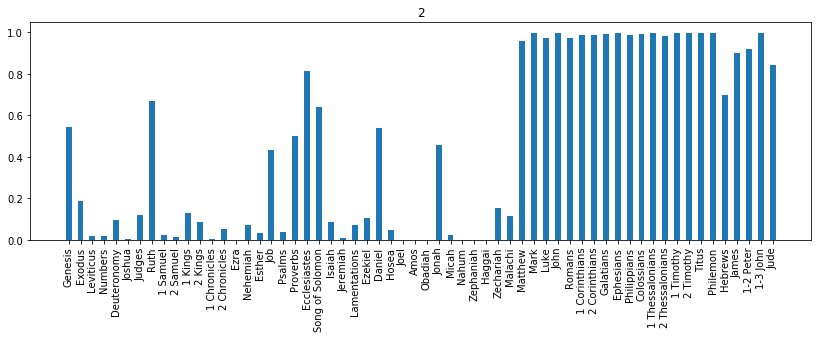

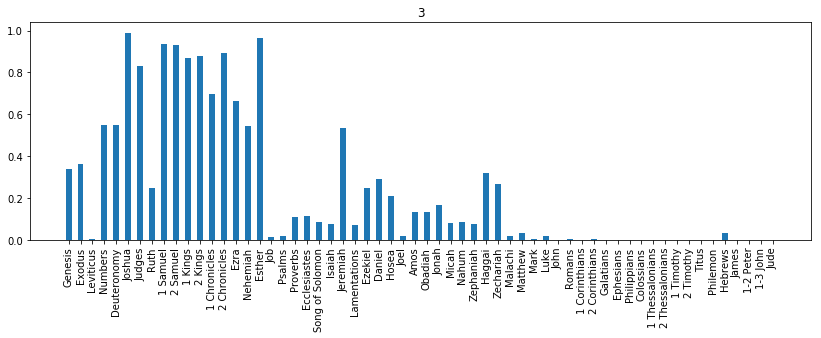

In [307]:
pset = set()  #set of all presidents
plist = []
for p in df['book']:
    if p not in pset:
        plist.append(p)
        pset.add(p)

weights=[]  #take the average over all speeches per president
for p in plist:
    line=[]
    indices = df.index[df['book'] == p]
    for i in indices:
        line.append(list(X_topics[i]))
    weights.append(list(np.mean(line, axis=0)))

#prepare plot - inspiration and code examples from https://de.dariah.eu/tatom/topic_model_visualization.html
N, K = len(weights), len(weights[0])
ind = np.arange(N)
width = 0.5 

#Plot for every single topic

for x in range(K):
    t = [] # alist with values for all 42 presidents for topic 1
    for entry in weights:
        t.append(entry[x])
    fig = plt.figure(figsize=(14,4))
    plt.bar(ind, t, width=width)
    plt.xticks(rotation=90)
    plt.xticks(ind , plist)
    plt.title(titles[x])

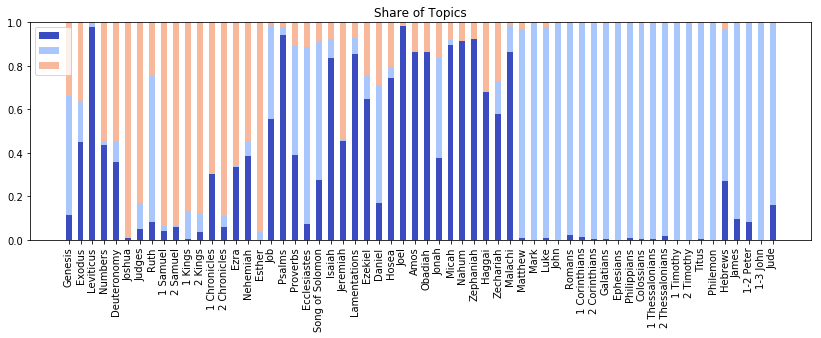

In [308]:
# #Stacked Bar plot
#prepare plot - inspiration and code examples from https://de.dariah.eu/tatom/topic_model_visualization.html
N, K = len(weights), len(weights[0])
ind = np.arange(N)
width = 0.5 
plots = []
height_cumulative = np.zeros(N)

s = []
for x in range(K):
    t = [] # alist with values for all 42 presidents for topic 1
    for entry in weights:
        t.append(entry[x])
    s.append(t)  #a list with 5 list, each with the weights on the respective topic per president
    
fig = plt.figure(figsize=(14,4))
for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, s[k], width, color=color)
    else:
        p = plt.bar(ind, s[k], width, bottom=height_cumulative, color=color)
    height_cumulative += s[k]
    plots.append(p)

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.title('Share of Topics')
plt.xticks(rotation=90)
plt.xticks(ind , plist)
  
for i in range(len(titles)):
    titles[i] = titles[i][15:]

plt.legend(titles,loc=2)
print()

## 4. Model 2 - Word2vec

on hold - Alex

## 5. Results